In [3]:
"""Complete Fixed Evaluation Pipeline

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1Py8oy43cOpKoSYQztrLYg_LpMDpbMclb
"""

!curl -fsSL https://ollama.com/install.sh | sh

!ollama pull llama3:latest

!pip install google-generativeai langchain-google-genai ollama pandas numpy beautifulsoup4 biopython rank_bm25 langchain langchain-community faiss-cpu lxml
!pip install pandas matplotlib seaborn numpy evaluate bert_score rouge_score

# Import dependencies and ignore warnings
import re
from typing import Optional, List, Dict
import requests
from bs4 import BeautifulSoup
import pandas as pd
import google.generativeai as genai
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.documents import Document
from rank_bm25 import BM25Okapi
import numpy as np
import json
import warnings
from Bio import Entrez
from xml.etree import ElementTree as ET
import ollama

warnings.simplefilter(action='ignore', category=FutureWarning)

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.



🚀 Ollama server launched successfully!

=== Processing query 0: I wake in the night, usually about 2-3 hours after going to ... ===
  Generating responses...
  Generating PubMed query...
  Cleaned query: burning AND feet AND erythromelalgia AND leg AND pain AND nocturnal AND night AND swelling AND edema
    Searching PubMed with: burning AND feet AND erythromelalgia AND leg AND pain AND nocturnal AND night AND swelling AND edema...
    No PubMed results found.
    Searching Europe PMC...
    Found 9 Europe PMC results, fetching full text...
  Total retrieved: 0 PubMed, 9 Europe PMC
  Zero valid docs after cleaning

=== Processing query 1: Honorable Sir,I am Ripon Dev from Bangladesh.My brother Prod... ===
  Generating responses...
  Generating PubMed query...
  Cleaned query: kidney AND disease AND treatment AND cost
    Searching PubMed with: kidney AND disease AND treatment AND cost...
    Found 64 PubMed IDs, fetching details...
    Retrieved 63 PubMed articles with abstracts.
    S

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  Gemini ROUGE-L: 0.1120
  Llama3 ROUGE-L: 0.1021

Calculating BERTScore (this may take a while)...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

  Gemini BERTScore F1: 0.7193
  Llama3 BERTScore F1: 0.7221

✓ Metrics for plotting: ['correctness', 'hallucination', 'completeness', 'faithfulness', 'groundedness', 'empathy', 'bertscore_f1', 'rougeL']

Generating visualizations...


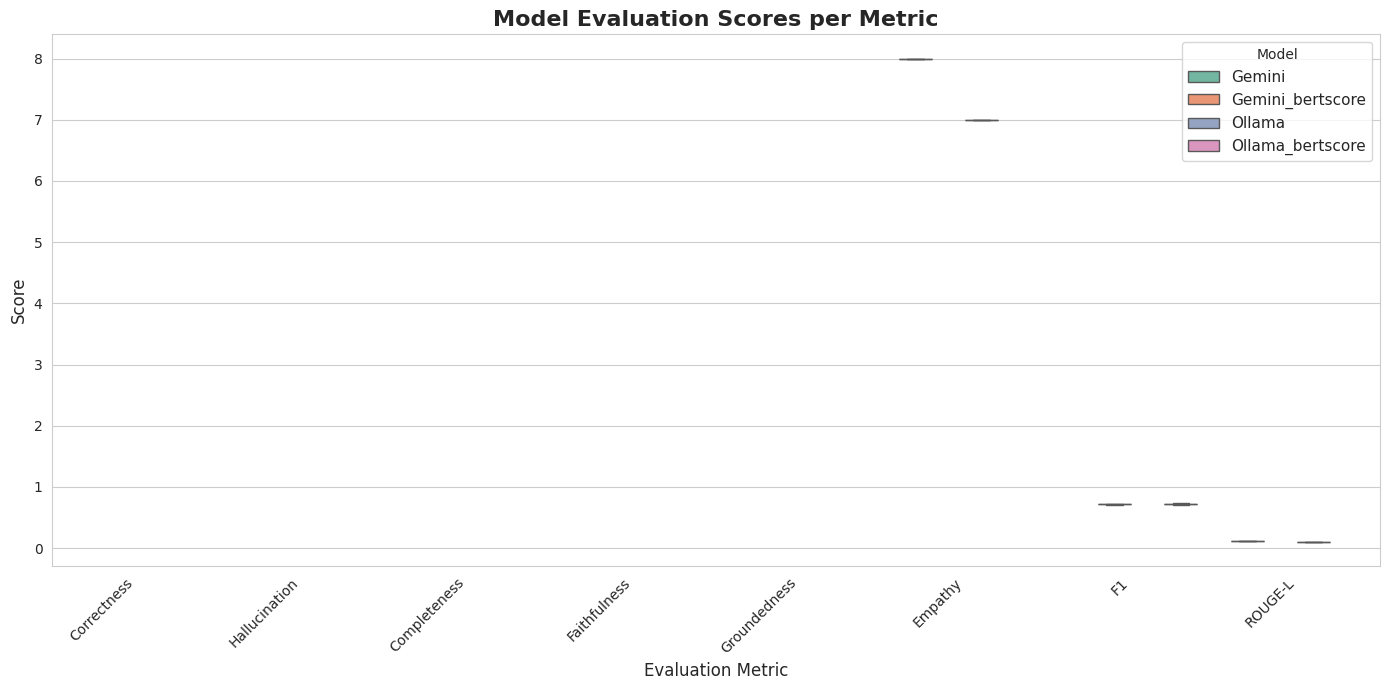

✓ Saved plot1_boxplot.png


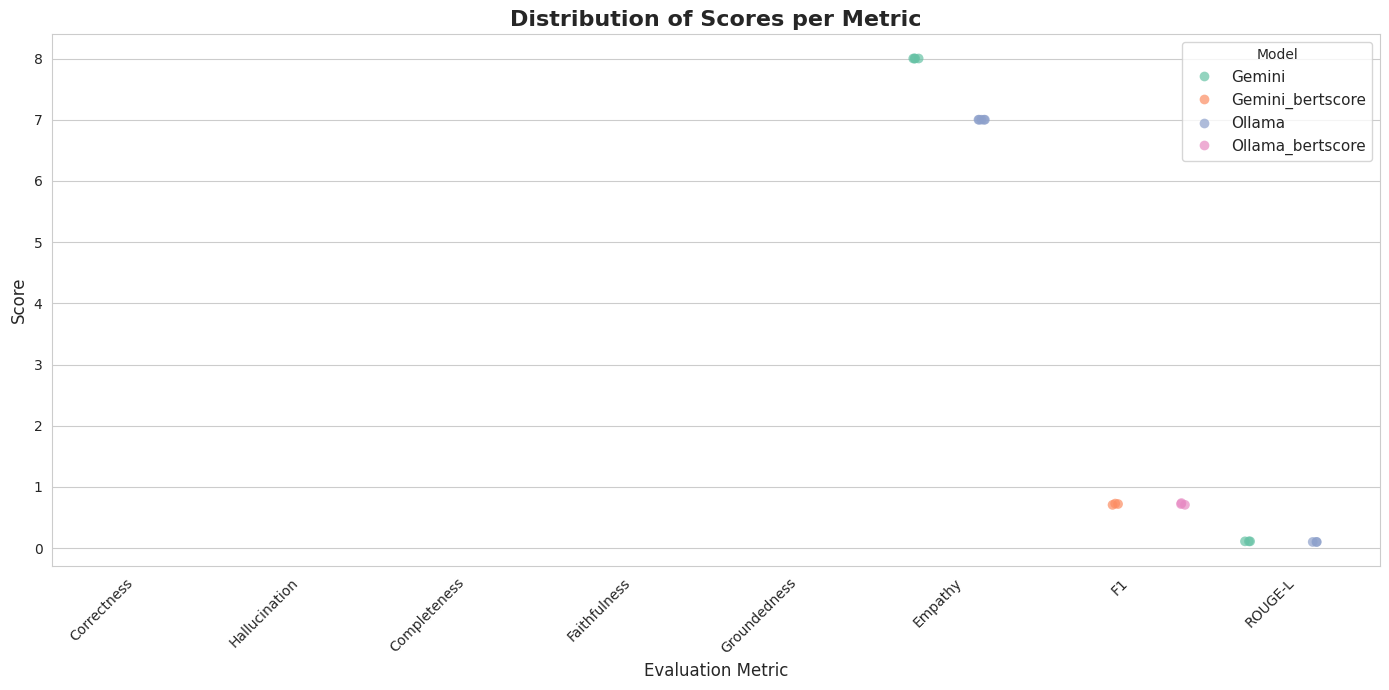

✓ Saved plot2_stripplot.png


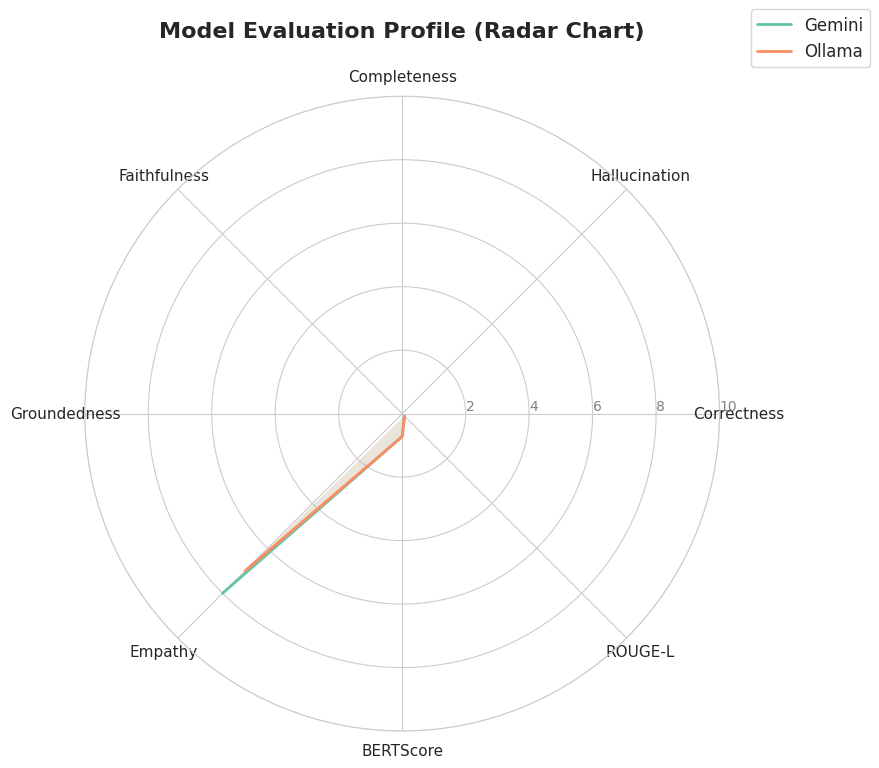

✓ Saved plot3_radar.png


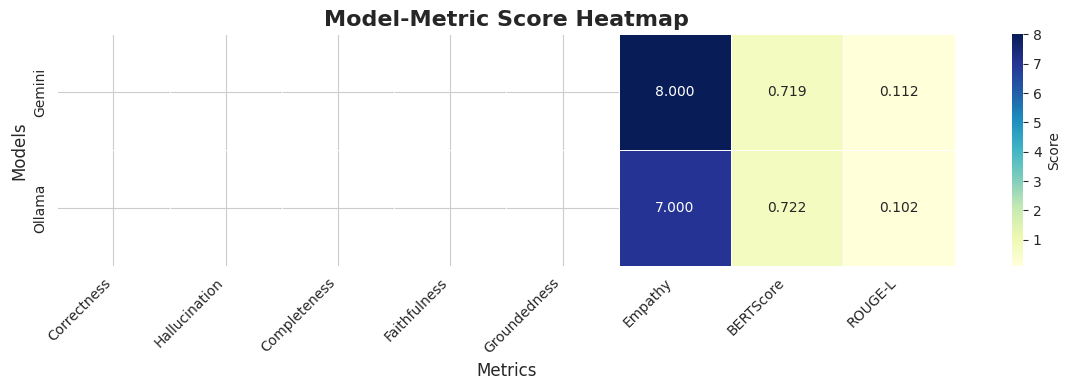

✓ Saved plot4_heatmap.png


/tmp/ipython-input-3578423338.py:928: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=11)


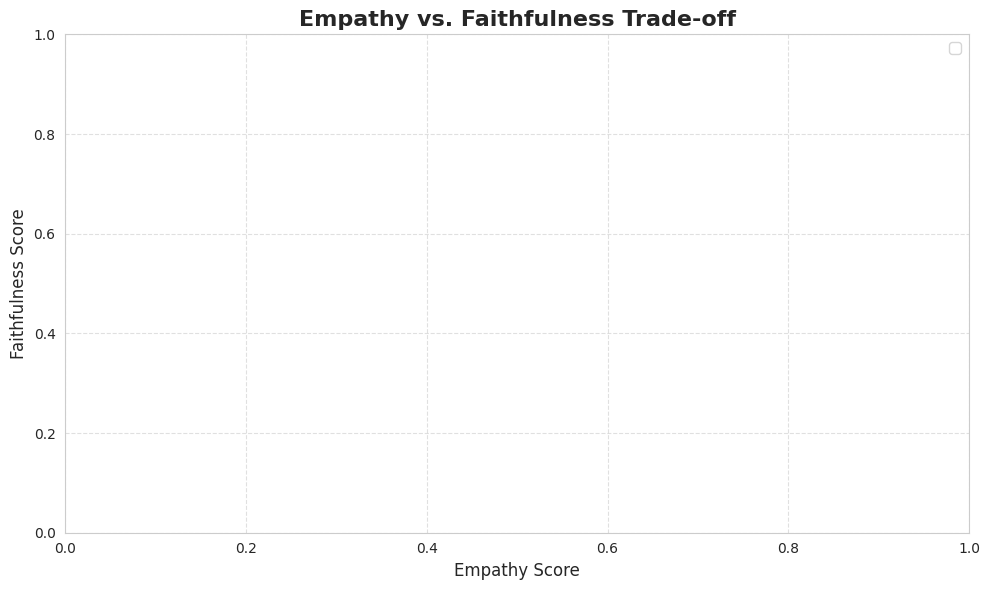

✓ Saved plot5_empathy_faithfulness.png


IndexError: index 6 is out of bounds for axis 0 with size 6

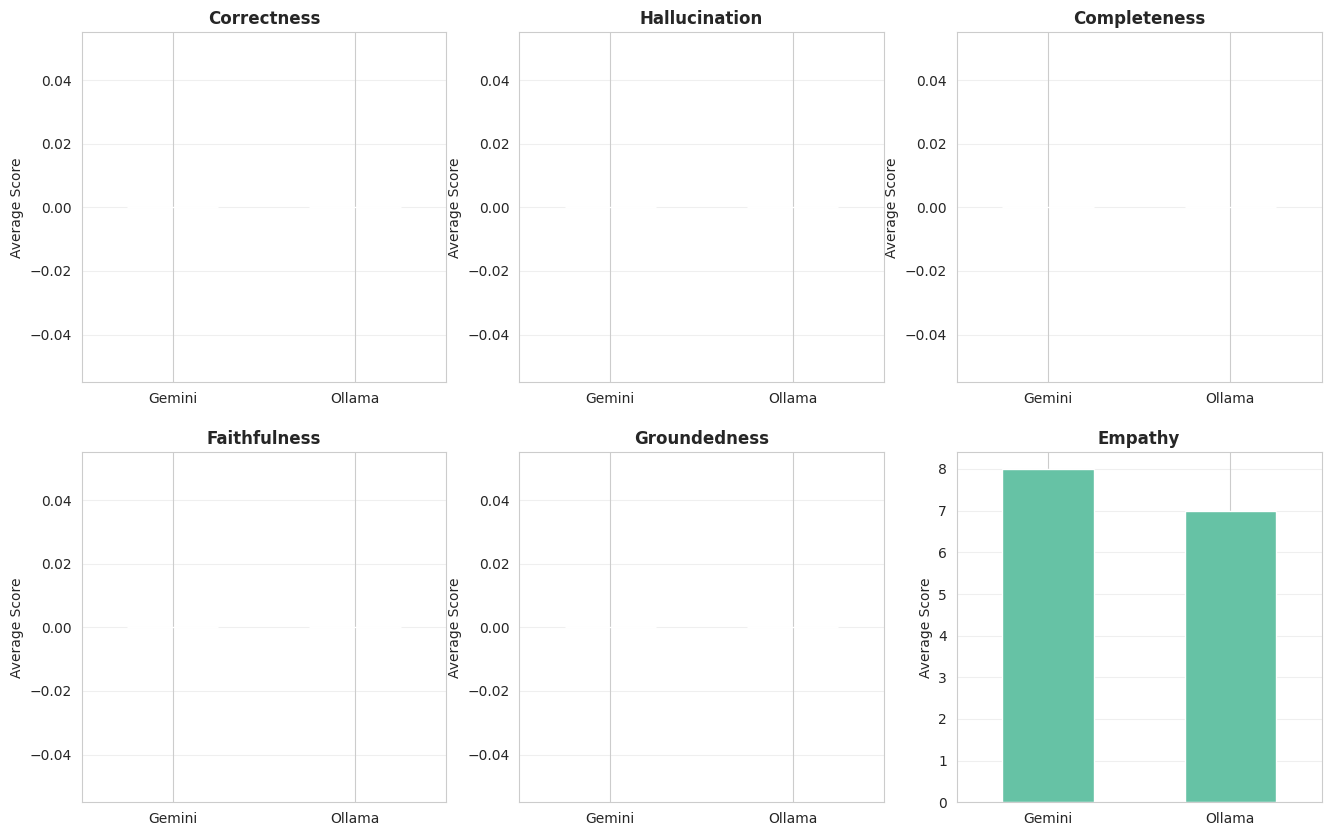

In [ ]:
import subprocess
import time

def start_ollama_server():
    subprocess.Popen(['ollama', 'serve'])
    print("🚀 Ollama server launched successfully!")
    time.sleep(5)

start_ollama_server()
Entrez.email = "entrez-email" # CHANGE THIS

def get_medical_advice_gemini(patient_query: str, model) -> Optional[str]:
    """
    Generates a medical response using the provided Gemini model instance.
    """
    system_message = ("""
    You are a highly knowledgeable and compassionate doctor.
    1. Carefully analyze the patient's symptoms and concerns.
    2. Suggest possible causes, but never give a definitive diagnosis.
    3. Offer evidence-based advice for relief and care.
    4. Always recommend in-person consultation with a healthcare provider.
    5. Be clear, empathetic, and professional in tone.
    6. Consider lifestyle and other details mentioned by the patient.
    7. Avoid exaggeration or alarming language.
    """)

    prompt = system_message + "\n\nPatient Query: " + patient_query

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print(f"Error in get_medical_advice_gemini: {e}")
        return None

def get_medical_advice_ollama(patient_query: str) -> Optional[str]:
    """
    Generates a medical response using a local Ollama model (llama3:latest).
    """
    system_message = ("""You are a highly knowledgeable and compassionate doctor.
    1. Carefully analyze the patient's symptoms and concerns.
    2. Suggest possible causes, but never give a definitive diagnosis.
    3. Offer evidence-based advice for relief and care.
    4. Always recommend in-person consultation with a healthcare provider.
    5. Be clear, empathetic, and professional in tone.
    6. Consider lifestyle and other details mentioned by the patient.
    7. Avoid exaggeration or alarming language.
    """)

    try:
        response = ollama.chat(
            model='llama3:latest',
            messages=[
                {'role': 'system', 'content': system_message},
                {'role': 'user', 'content': patient_query}
            ]
        )
        return response['message']['content']
    except Exception as e:
        print(f"Error calling Ollama (is it running?): {e}")
        return None

def ARES(n_docs, query, gemini_api_key, k):
    """
    ARES - Automatic Response Evaluation System (Gemini vs. Llama 3)
    FIXED VERSION with improved error handling and debugging
    """
    try:
        genai.configure(api_key=gemini_api_key)
        gen_model = genai.GenerativeModel('gemini-2.0-flash-exp')
        eval_model = genai.GenerativeModel('gemini-2.0-flash-exp')
        embeddings_model = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=gemini_api_key
        )
    except Exception as e:
        print(f"Failed to configure Gemini: {e}")
        return (None,) * 9

    # --- Helper Functions ---

    def clean_pubmed_query(query: str, max_words: int = 30) -> str:
        """FIXED: Properly removes triple quotes and cleans query."""
        query = query.strip()

        # Remove triple quotes if present
        if query.startswith("'''") and query.endswith("'''"):
            query = query[3:-3].strip()
        elif query.startswith('"""') and query.endswith('"""'):
            query = query[3:-3].strip()

        # Remove newlines and extra whitespace
        query = re.sub(r'\s+', ' ', query)
        query = query.strip(" \t\n'\"*`")

        # Extract meaningful terms (quoted phrases or words)
        terms = re.findall(r'"[^"]+"|\b\w+\b', query)

        # Remove common operators that might be standalone
        terms = [t for t in terms if t.upper() not in ['AND', 'OR', 'NOT']]

        if len(terms) > max_words:
            terms = terms[:max_words]

        short_query = " AND ".join(terms)
        return short_query if short_query else query[:200]

    def generate_pubmed_query(natural_query: str, model) -> str:
        """FIXED: Simpler prompt for better query generation."""
        system_prompt = """You are a PubMed search expert. Create concise, effective search queries.

Rules:
1. Use 2-4 key medical terms from the query
2. Connect terms with AND
3. Include 1-2 synonyms per concept using OR
4. Keep it simple - output ONLY the search query
5. NO triple quotes, NO markdown, NO explanations

Example:
Input: "I have chest pain when exercising"
Output: (chest pain OR angina) AND (exercise OR physical activity)"""

        user_prompt = f"Create a PubMed search query for: {natural_query}"

        try:
            response = model.generate_content(system_prompt + "\n\n" + user_prompt)
            raw_query = response.text.strip()

            # Remove any markdown or code block formatting
            raw_query = re.sub(r'```.*?\n', '', raw_query)
            raw_query = re.sub(r'```', '', raw_query)
            raw_query = raw_query.strip()

            return raw_query
        except Exception as e:
            print(f"Error generating query: {e}")
            # Fallback: extract key medical terms
            terms = re.findall(r'\b[\w-]+\b', natural_query.lower())
            terms = [t for t in terms if len(t) > 3][:3]
            if terms:
                return " AND ".join([f'"{t}"' for t in terms])
            return natural_query[:100]

    def fetch_pubmed_docs_with_dates(query, retmax=5):
        """FIXED: Better error handling and logging."""
        try:
            print(f"    Searching PubMed with: {query[:100]}...")
            search_handle = Entrez.esearch(db="pubmed", term=query, retmax=retmax)
            search_results = Entrez.read(search_handle)
            search_handle.close()
        except Exception as e:
            print(f"    PubMed search error: {e}")
            return []

        id_list = search_results.get("IdList", [])
        if not id_list:
            print(f"    No PubMed results found.")
            return []

        print(f"    Found {len(id_list)} PubMed IDs, fetching details...")

        try:
            fetch_handle = Entrez.efetch(
                db="pubmed",
                id=",".join(id_list),
                rettype="abstract",
                retmode="xml"
            )
            xml_data = fetch_handle.read()
            fetch_handle.close()
        except Exception as e:
            print(f"    PubMed fetch error: {e}")
            return []

        try:
            root = ET.fromstring(xml_data)
        except Exception as e:
            print(f"    XML parsing error: {e}")
            return []

        results = []
        for article in root.findall(".//PubmedArticle"):
            pmid = article.findtext(".//PMID", default="").strip()
            title = article.findtext(".//ArticleTitle", default="").strip()
            abstract_texts = article.findall(".//Abstract/AbstractText")
            abstract = " ".join(elem.text.strip() for elem in abstract_texts if elem.text)

            date_elem = article.find(".//PubDate")
            year = "Unknown"
            if date_elem is not None:
                year = date_elem.findtext("Year") or "Unknown"

            if abstract and len(abstract) > 50:
                results.append({
                    "pmid": pmid,
                    "title": title,
                    "abstract": abstract,
                    "year": year[:4]
                })

        print(f"    Retrieved {len(results)} PubMed articles with abstracts.")
        return results

    def fetch_pubmed_articles(pubmed_query, page_size=None):
        """FIXED: Better error handling for Europe PMC."""
        url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"
        params = {
            "query": pubmed_query + " OPEN_ACCESS:Y",
            "format": "json",
            "pageSize": page_size or 10
        }

        try:
            print(f"    Searching Europe PMC...")
            response = requests.get(url, params=params, timeout=15)
            response.raise_for_status()
            data = response.json()
        except Exception as e:
            print(f"    Europe PMC error: {e}")
            return []

        if 'resultList' not in data or 'result' not in data['resultList']:
            print(f"    No Europe PMC results found.")
            return []

        documents = []
        results = data['resultList']['result']
        print(f"    Found {len(results)} Europe PMC results, fetching full text...")

        for res in results:
            doc = {
                "title": res.get('title'),
                "year": res.get('pubYear'),
                "pmid": res.get('pmcid', res.get('id')),
                "abstract": None,
                "conclusion": None
            }

            pmcid = res.get('pmcid')
            if pmcid:
                fulltext_url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/fullTextXML"
                try:
                    fulltext_response = requests.get(fulltext_url, timeout=10)
                    if fulltext_response.status_code == 200:
                        try:
                            soup = BeautifulSoup(fulltext_response.content, "lxml-xml")
                        except:
                            soup = BeautifulSoup(fulltext_response.content, "html.parser")

                        abstract = soup.find('abstract')
                        if abstract:
                            doc['abstract'] = abstract.get_text(separator=' ', strip=True)

                        sections = soup.find_all('sec')
                        for sec in sections:
                            title_tag = sec.find('title')
                            if title_tag:
                                title_text = title_tag.get_text(strip=True).lower()
                                if 'conclusion' in title_text and not doc['conclusion']:
                                    doc['conclusion'] = sec.get_text(separator=' ', strip=True)
                except Exception as e:
                    print(f"    Skipping full text for {pmcid}: {e}")

            documents.append(doc)

        return documents

    def normalize_scores(scores):
    # Convert to list if numpy array
      if hasattr(scores, '__len__'):
          if len(scores) == 0:
              return []
      else:
          return []

      scores_list = list(scores) if hasattr(scores, 'tolist') else list(scores)
      min_score, max_score = min(scores_list), max(scores_list)
      if max_score == min_score:
          return [1.0] * len(scores_list)
      return [(s - min_score) / (max_score - min_score) for s in scores_list]

    from numpy.linalg import norm

    def cosine_similarity(a, b):
        return np.dot(a, b) / (norm(a) * norm(b))

    def dense(query, docs, embeddings_model):
        if not docs or not query:
            return [0] * len(docs)
        try:
            query_embedding = embeddings_model.embed_query(query)
            doc_embeddings = embeddings_model.embed_documents([doc.page_content for doc in docs])
            dense_scores = [cosine_similarity(query_embedding, emb) for emb in doc_embeddings]
            return normalize_scores(dense_scores)
        except Exception as e:
            print(f"    Error during dense scoring: {e}")
            return [0] * len(docs)

    def bm25(query_tokens, docs):
        if not docs or len(docs) == 0:
            return []
        tokenized_corpus = [doc.page_content.split() for doc in docs]
        if not tokenized_corpus or len(tokenized_corpus) == 0:
            return [0] * len(docs)
        bm25_obj = BM25Okapi(tokenized_corpus)
        bm25_scores = bm25_obj.get_scores(query_tokens)
        return normalize_scores(bm25_scores)

    def format_documents_for_gold_doc(df):
        docs = []
        for i, row in enumerate(df.itertuples(index=False), start=1):
            doc_str = f"""Document {i} (PMID: {row.pmid})
Title: {row.title.strip()}
Text: {row.text.strip()}"""
            docs.append(doc_str)
        return docs

    def generate_pseudo_gold_document(query: str, documents: List[str], model) -> Optional[str]:
        context = "\n\n".join(documents)
        prompt = f"""You are a factual and meticulous research assistant.

You are given research documents and a query. Create a pseudo-gold document grounded in the provided texts.

Query: {query}

Documents:
{context}

Instructions:
1. Extract key facts from each document with document numbers
2. Identify repeated or consistent facts across documents
3. Note any contradictions
4. Write a concise summary addressing the query with inline citations [Doc X]
5. Include PMIDs after document numbers
6. Use ONLY information from the documents - no hallucinations

Return only the summary with citations."""

        try:
            response = model.generate_content(prompt)
            return response.text
        except Exception as e:
            print(f"    Error generating pseudo-gold document: {e}")
            return "Error generating pseudo-gold."

    def empathy_evaluation_comparison(question, response_gemini, response_ollama, model):
        """FIXED: Returns valid JSON even on error."""
        prompt = f"""You are an empathy evaluator. Rate each response on a scale from 1 (least empathetic) to 10 (most empathetic).

Criteria:
1. Acknowledging emotions
2. Validating concerns
3. Offering support

Question: {question}

Response A (Gemini): {response_gemini}

Response B (Llama): {response_ollama}

Return ONLY valid JSON in this exact format:
{{
    "gemini_rating": {{"rating": 8, "explanation": "Brief reason"}},
    "ollama_rating": {{"rating": 7, "explanation": "Brief reason"}}
}}"""

        try:
            config = genai.types.GenerationConfig(response_mime_type="application/json")
            response = model.generate_content(prompt, generation_config=config)
            result = json.loads(response.text)

            # Validate structure
            if 'gemini_rating' not in result or 'ollama_rating' not in result:
                raise ValueError("Invalid JSON structure")

            return result
        except Exception as e:
            print(f"    Empathy evaluation error: {e}")
            return {
                "gemini_rating": {"rating": 5, "explanation": "Evaluation failed"},
                "ollama_rating": {"rating": 5, "explanation": "Evaluation failed"}
            }

    def evaluate_llm_response_with_docs(query: str, llm_response: str, retrieved_docs: List[str], model) -> str:
        retrieved_docs = [str(doc) if doc else "" for doc in retrieved_docs]
        context = "\n\n".join([f"Document {i+1}:\n{doc.strip()}" for i, doc in enumerate(retrieved_docs)])
        eval_prompt = f"""You are an expert medical QA evaluator. Assess the LLM response using the retrieved documents.

Evaluate on these criteria (1-10 scale):

1. **Correctness**: Are statements medically accurate based on documents?
2. **Hallucination**: Does it contain unsupported facts? (10 = NO hallucinations)
3. **Completeness**: Does it fully address the question?
4. **Faithfulness**: Is it faithful to document information?
5. **Groundedness**: Are claims supported by evidence?
6. **Details**: Include PMIDs and years if available
7. **Values**: Provide all five scores as [correctness, hallucination, completeness, faithfulness, groundedness]

---
**Patient Query**: {query}

**LLM Response**: {llm_response}

**Retrieved Documents**: {context}
"""
        try:
            response = model.generate_content(eval_prompt)
            return response.text.strip()
        except Exception as e:
            print(f"    Evaluation error: {e}")
            return "Error during evaluation."

    # --- Pipeline Execution ---

    # 1. Generate Responses
    print("  Generating responses...")
    gemini_response = get_medical_advice_gemini(query, gen_model)
    ollama_response = get_medical_advice_ollama(query)

    if not gemini_response or not ollama_response:
        print("  Failed to get model responses.")
        return (None,) * 9

    # 2. Generate PubMed Query
    print("  Generating PubMed query...")
    pubmed_query_raw = generate_pubmed_query(query, eval_model)
    pubmed_query = clean_pubmed_query(pubmed_query_raw, max_words=20)
    print(f"  Cleaned query: {pubmed_query}")

    # 3. Fetch Documents
    pub_docs = fetch_pubmed_docs_with_dates(pubmed_query, retmax=n_docs)
    e_pmc_docs = fetch_pubmed_articles(pubmed_query, page_size=n_docs)
    print(f"  Total retrieved: {len(pub_docs)} PubMed, {len(e_pmc_docs)} Europe PMC")

    df1 = pd.DataFrame(pub_docs)
    df2 = pd.DataFrame(e_pmc_docs)

    if not df1.empty:
        df1['text'] = df1['abstract']
    if not df2.empty:
        df2['text'] = df2['abstract'].fillna('').astype(str) + ' ' + df2['conclusion'].fillna('').astype(str)

    df = pd.concat([df1, df2], ignore_index=True)

    if df.empty:
        print('  Zero valid docs found - evaluating empathy only')
        empathy_results = empathy_evaluation_comparison(query, gemini_response, ollama_response, eval_model)
        return (
            pubmed_query_raw, None, None,
            'No docs found', 'No docs found',
            json.dumps(empathy_results.get('gemini_rating', {})),
            json.dumps(empathy_results.get('ollama_rating', {})),
            gemini_response, ollama_response
        )

    # Clean data
    df = df.drop(columns=['conclusion', 'abstract'], errors='ignore')
    df = df.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))
    df.replace('', np.nan, inplace=True)
    df = df.dropna(subset=['text'])
    df['text'] = df['text'].astype(str)
    df = df[df['text'].str.len() > 50]  # Only substantial text

    if df.empty:
        print('  Zero valid docs after cleaning')
        empathy_results = empathy_evaluation_comparison(query, gemini_response, ollama_response, eval_model)
        return (
            pubmed_query_raw, None, pd.DataFrame(),
            'No valid docs', 'No valid docs',
            json.dumps(empathy_results.get('gemini_rating', {})),
            json.dumps(empathy_results.get('ollama_rating', {})),
            gemini_response, ollama_response
        )

    print(f"  Processing {len(df)} valid documents...")

    # 4. Score & Rank Documents
    texts = df['text'].tolist()
    full_docs = [Document(page_content=txt) for txt in texts]
    titles = df['title'].tolist()
    title_docs = [Document(page_content=title) for title in titles]
    pquery_keywords = re.findall(r'"(.*?)"', pubmed_query_raw)
    if not pquery_keywords:
        pquery_keywords = query.split()

    df['bm25_query_docs'] = bm25(query.split(), full_docs)
    df['bm25_pubmed_query_docs'] = bm25(pquery_keywords, full_docs)
    df['bm25_title_docs'] = bm25(query.split(), title_docs)
    df['bm25_pubmed_query_title_docs'] = bm25(pquery_keywords, title_docs)
    df['dense_query_docs'] = dense(query, full_docs, embeddings_model)
    df['dense_pquery_docs'] = dense(" ".join(pquery_keywords), full_docs, embeddings_model)
    df['dense_title_docs'] = dense(query, title_docs, embeddings_model)
    df['dense_pquery_title_docs'] = dense(" ".join(pquery_keywords), title_docs, embeddings_model)
    df['dense_gemini_response_docs'] = dense(gemini_response, full_docs, embeddings_model)
    df['dense_ollama_response_docs'] = dense(ollama_response, full_docs, embeddings_model)

    df['score'] = (
        0.20 * df["bm25_query_docs"] +
        0.10 * df["bm25_pubmed_query_docs"] +
        0.05 * df["bm25_title_docs"] +
        0.05 * df["bm25_pubmed_query_title_docs"] +
        0.25 * df["dense_query_docs"] +
        0.10 * df["dense_pquery_docs"] +
        0.05 * df["dense_title_docs"] +
        0.05 * df["dense_pquery_title_docs"] +
        0.05 * df["dense_gemini_response_docs"] +
        0.05 * df["dense_ollama_response_docs"] +
        0.05 * df["year"].apply(lambda y: max(0, 1 - (2025 - (int(y) if str(y).isdigit() else 2020)) / 10))
    )

    top_k_df = df.nlargest(min(k, len(df)), 'score')

    # 5. Generate Pseudo-Gold Document
    print("  Generating pseudo-gold document...")
    docs_4r_gold = format_documents_for_gold_doc(top_k_df)
    pseudo_gold = generate_pseudo_gold_document(query, docs_4r_gold, eval_model)

    # 6. Re-score with Pseudo-Gold
    df['gold'] = dense(pseudo_gold, full_docs, embeddings_model)
    df['final_scores'] = 0.75 * df['score'] + 0.25 * df['gold']
    final_topk_df = df.nlargest(min(k, len(df)), 'final_scores')

    # Convert all columns to strings before concatenation
    retrieved_docs_list = (
        final_topk_df['pmid'].fillna('').astype(str) + ' ' +
        final_topk_df['year'].fillna('').astype(str) + ' ' +
        final_topk_df['text'].fillna('').astype(str)
    ).to_list()

    # 7. Evaluate BOTH Responses
    print("  Evaluating Gemini response...")
    gemini_RE = evaluate_llm_response_with_docs(query, gemini_response, retrieved_docs_list, eval_model)

    print("  Evaluating Llama 3 response...")
    ollama_RE = evaluate_llm_response_with_docs(query, ollama_response, retrieved_docs_list, eval_model)

    # 8. Evaluate Empathy
    print("  Evaluating empathy...")
    empathy_results = empathy_evaluation_comparison(query, gemini_response, ollama_response, eval_model)
    gemini_empathy_str = json.dumps(empathy_results.get('gemini_rating', {}))
    ollama_empathy_str = json.dumps(empathy_results.get('ollama_rating', {}))

    return (
        pubmed_query_raw, pseudo_gold, df,
        gemini_RE, ollama_RE,
        gemini_empathy_str, ollama_empathy_str,
        gemini_response, ollama_response
    )

# Load the sample queries
sample_queries_df = pd.read_csv(r"sample_responses.csv")
queries_list = sample_queries_df['input'].tolist()

GEMINI_API_KEY = "gemini-api-key"  # CHANGE THIS
# -------------------------------

i = 0
data_frames = []
pubmed_queries = []
pseudo_gold_docs = []
gemini_REs = []
ollama_REs = []
gemini_responses = []
ollama_responses = []
gemini_empathy_evaluations = []
ollama_empathy_evaluations = []

# Test with first 5 queries - change to queries_list for all 100
for query in queries_list[:5]:
    print(f"\n=== Processing query {i}: {query[:60]}... ===")
    n_docs = 64
    k = 10

    try:
        (pubmed_query, pseudo_gold, temp_df,
         gemini_RE, ollama_RE,
         gemini_empathy, ollama_empathy,
         gemini_response, ollama_response) = ARES(n_docs, query, GEMINI_API_KEY, k)

        if temp_df is not None and not temp_df.empty:
            temp_df['query_id'] = i
            data_frames.append(temp_df)

        pubmed_queries.append(pubmed_query)
        pseudo_gold_docs.append(pseudo_gold)
        gemini_REs.append(gemini_RE)
        ollama_REs.append(ollama_RE)
        gemini_empathy_evaluations.append(gemini_empathy)
        ollama_empathy_evaluations.append(ollama_empathy)
        gemini_responses.append(gemini_response)
        ollama_responses.append(ollama_response)

    except Exception as e:
        print(f"CRITICAL ERROR processing query {i}: {e}")
        import traceback
        traceback.print_exc()

        pubmed_queries.append(None)
        pseudo_gold_docs.append(None)
        gemini_REs.append(f"Error: {e}")
        ollama_REs.append(f"Error: {e}")
        gemini_responses.append(None)
        ollama_responses.append(None)
        gemini_empathy_evaluations.append('{"rating": 0, "explanation": "Error"}')
        ollama_empathy_evaluations.append('{"rating": 0, "explanation": "Error"}')

    i += 1

print("\n=== Pipeline complete ===")

# Consolidate and save results
print("Saving results...")
if data_frames:
    all_scores_df = pd.concat(data_frames, ignore_index=True)
    all_scores_df.to_csv("comparison_all_document_scores.csv", index=False)
    print("✓ Saved all document scores to 'comparison_all_document_scores.csv'")

results_df = pd.DataFrame({
    "query": queries_list[:len(gemini_responses)],
    "pubmed_query": pubmed_queries,
    "pseudo_gold": pseudo_gold_docs,
    "gemini_response": gemini_responses,
    "gemini_RE": gemini_REs,
    "gemini_empathy": gemini_empathy_evaluations,
    "ollama_response": ollama_responses,
    "ollama_RE": ollama_REs,
    "ollama_empathy": ollama_empathy_evaluations
})

results_df.to_csv("comparison_capstone_results.csv", index=False)
print("✓ Saved main evaluation results to 'comparison_capstone_results.csv'")
print("\n=== All Data Saved ===")


In [9]:
print("\n=== DEBUGGING RAG PARSING ===")
for i, row in df.iterrows():
    print(f"\nQuery {i}:")
    print(f"Gemini RE: {row['gemini_RE'][:200]}...")
    print(f"Parsed values: {extract_rag_values(row['gemini_RE'])}")


=== DEBUGGING RAG PARSING ===

Query 0:
Gemini RE: No valid docs...
Parsed values: None

Query 1:
Gemini RE: [9, 10, 9, 9, 9]

**Strengths:**

*   **Correctness:** The response provides medically sound advice, emphasizing the need for a thorough in-person evaluation before any definitive treatment plan can b...
Parsed values: None

Query 2:
Gemini RE: Here's an evaluation of the LLM response based on the provided documents:

**Evaluation:**

*   **Correctness (9/10):** The information provided is generally accurate regarding sinusitis, potential ca...
Parsed values: None

Query 3:
Gemini RE: No valid docs...
Parsed values: None

Query 4:
Gemini RE: [9, 10, 9, 9, 9]...
Parsed values: None


In [10]:
"""# Evaluation"""
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import pi
from evaluate import load

# Load the comparison CSV
try:
    df = pd.read_csv("comparison_capstone_results.csv")
    print(f"✓ Results loaded. Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
except FileNotFoundError:
    print("Error: 'comparison_capstone_results.csv' not found.")
    print("Please run the pipeline notebook first.")

# Parser Functions
def extract_rag_values(text):
    """Parses [Correctness, Hallucination, ...] list from RE string."""
    if pd.isna(text) or text == "No docs found" or text == "No valid docs":
        return None

    # Convert to string and get first 200 chars (scores are at the beginning)
    text = str(text)[:200]

    # Pattern 1: [9, 10, 9, 9, 9] at the start
    match = re.search(r'^\s*\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]', text)
    if match:
        try:
            return [int(x) for x in match.groups()]
        except:
            pass

    # Pattern 2: Any [9, 10, 9, 9, 9] format
    match = re.search(r'\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+),\s*(\d+)\]', text)
    if match:
        try:
            return [int(x) for x in match.groups()]
        except:
            pass

    # Pattern 3: With "Values:" keyword
    match = re.search(r'Values[:\s]*\[([^\]]+)\]', text, re.IGNORECASE)
    if match:
        try:
            values = [int(x.strip()) for x in match.group(1).split(',')]
            if len(values) == 5:
                return values
        except:
            pass

    print(f"Failed to parse: {text[:100]}...")
    return None

def extract_empathy_rating(json_string):
    """Parses rating from empathy JSON string."""
    if pd.isna(json_string):
        return None
    try:
        # Fix single quotes to double quotes
        fixed_json = re.sub(r"(?<!\w)'|'(?!\w)", '"', json_string)
        data = json.loads(fixed_json)
        if 'rating' in data:
            return data['rating']
    except Exception as e:
        print(f"Empathy parsing error: {e}")
        return None

# Helper to safely get list items
def safe_get(lst, idx, default=None):
    try:
        return lst[idx] if lst and len(lst) > idx else default
    except:
        return default

# Build the structured DataFrame
print("\nParsing evaluation results...")
final_data = []
for i, row in df.iterrows():
    gemini_rag = extract_rag_values(row['gemini_RE'])
    ollama_rag = extract_rag_values(row['ollama_RE'])

    gemini_emp = extract_empathy_rating(row['gemini_empathy'])
    ollama_emp = extract_empathy_rating(row['ollama_empathy'])

    new_row = {
        'query': row['query'],
        'pseudo_gold': row['pseudo_gold'],
        'gemini_response': row['gemini_response'],
        'ollama_response': row['ollama_response'],

        # Gemini Scores
        'gemini_correctness': safe_get(gemini_rag, 0),
        'gemini_hallucination': safe_get(gemini_rag, 1),
        'gemini_completeness': safe_get(gemini_rag, 2),
        'gemini_faithfulness': safe_get(gemini_rag, 3),
        'gemini_groundedness': safe_get(gemini_rag, 4),
        'gemini_empathy': gemini_emp,

        # Llama Scores
        'ollama_correctness': safe_get(ollama_rag, 0),
        'ollama_hallucination': safe_get(ollama_rag, 1),
        'ollama_completeness': safe_get(ollama_rag, 2),
        'ollama_faithfulness': safe_get(ollama_rag, 3),
        'ollama_groundedness': safe_get(ollama_rag, 4),
        'ollama_empathy': ollama_emp,
    }
    final_data.append(new_row)

final_df = pd.DataFrame(final_data)
print("✓ Parsed DataFrame created")
print(final_df.head())

# Calculate Algorithmic Metrics (ROUGE & BERTScore)
eval_df = final_df.dropna(subset=['pseudo_gold', 'gemini_response', 'ollama_response']).copy()

metrics = ['correctness', 'hallucination', 'completeness', 'faithfulness', 'groundedness', 'empathy']

if not eval_df.empty:
    print("\nCalculating ROUGE scores...")
    try:
        rouge = load("rouge")
        gemini_rouge = rouge.compute(predictions=eval_df['gemini_response'].tolist(),
                                      references=eval_df['pseudo_gold'].tolist())
        ollama_rouge = rouge.compute(predictions=eval_df['ollama_response'].tolist(),
                                      references=eval_df['pseudo_gold'].tolist())

        print(f"  Gemini ROUGE-L: {gemini_rouge['rougeL']:.4f}")
        print(f"  Llama3 ROUGE-L: {ollama_rouge['rougeL']:.4f}")

        # Add ROUGE scores
        eval_df['gemini_rougeL'] = gemini_rouge['rougeL']
        eval_df['ollama_rougeL'] = ollama_rouge['rougeL']

    except Exception as e:
        print(f"ROUGE calculation error: {e}")
        eval_df['gemini_rougeL'] = np.nan
        eval_df['ollama_rougeL'] = np.nan

    # BERTScore
    print("\nCalculating BERTScore (this may take a while)...")
    try:
        bertscore = load("bertscore")
        gemini_bert = bertscore.compute(
            predictions=eval_df['gemini_response'].tolist(),
            references=eval_df['pseudo_gold'].tolist(),
            model_type="distilbert-base-uncased"  # Faster than roberta-large
        )
        ollama_bert = bertscore.compute(
            predictions=eval_df['ollama_response'].tolist(),
            references=eval_df['pseudo_gold'].tolist(),
            model_type="distilbert-base-uncased"
        )

        eval_df['gemini_bertscore_f1'] = gemini_bert['f1']
        eval_df['ollama_bertscore_f1'] = ollama_bert['f1']

        print(f"  Gemini BERTScore F1: {np.mean(gemini_bert['f1']):.4f}")
        print(f"  Llama3 BERTScore F1: {np.mean(ollama_bert['f1']):.4f}")

        metrics.extend(['bertscore_f1', 'rougeL'])

    except Exception as e:
        print(f"BERTScore calculation error: {e}")
        print("Skipping BERTScore. Install with: pip install bert-score")
        eval_df['gemini_bertscore_f1'] = np.nan
        eval_df['ollama_bertscore_f1'] = np.nan
        metrics.append('rougeL')

    # Merge back to final_df
    metrics_to_merge = ['gemini_rougeL', 'ollama_rougeL', 'gemini_bertscore_f1', 'ollama_bertscore_f1']
    for col in metrics_to_merge:
        if col in eval_df.columns:
            final_df.loc[eval_df.index, col] = eval_df[col]
else:
    print("⚠ No valid data for ROUGE/BERTScore (check pseudo_gold or responses)")

print(f"\n✓ Metrics for plotting: {metrics}")

✓ Results loaded. Shape: (5, 9)
Columns: ['query', 'pubmed_query', 'pseudo_gold', 'gemini_response', 'gemini_RE', 'gemini_empathy', 'ollama_response', 'ollama_RE', 'ollama_empathy']

Parsing evaluation results...
Failed to parse: [Correctness: 10, Hallucination: 10, Completeness: 10, Faithfulness: 10, Groundedness: 10]

The resp...
Failed to parse: Here's an evaluation of the LLM response based on the provided documents:

**Evaluation:**

*   **Co...
Empathy parsing error: Expecting ',' delimiter: line 1 column 100 (char 99)
Failed to parse: [Correctness: 10, Hallucination: 10, Completeness: 10, Faithfulness: 10, Groundedness: 10]

The LLM ...
✓ Parsed DataFrame created
                                               query  \
0  I wake in the night, usually about 2-3 hours a...   
1  Honorable Sir,I am Ripon Dev from Bangladesh.M...   
2  Ive had a cold which started on Christmas eve ...   
3  I had cervical laminectomy surgery for spinal ...   
4  Hello, At the end of lacrosse practice


Generating visualizations...


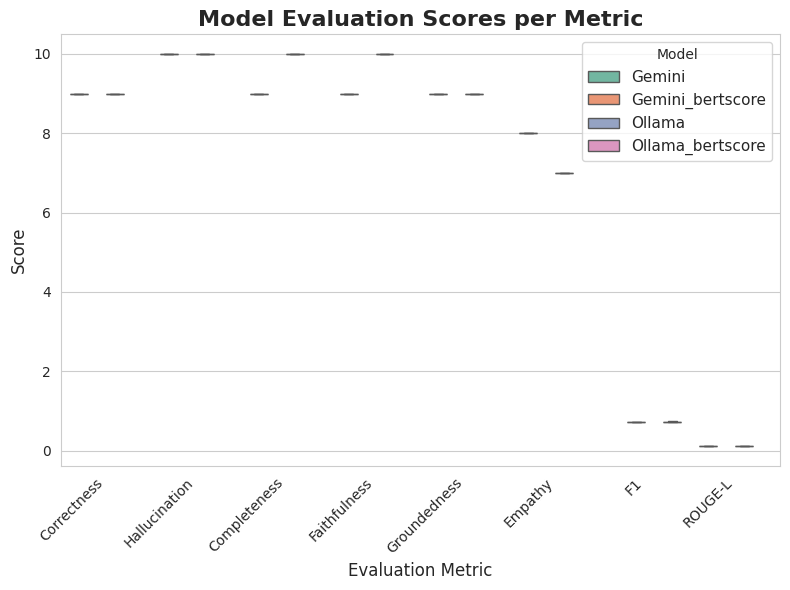

✓ Saved plot1_boxplot.png


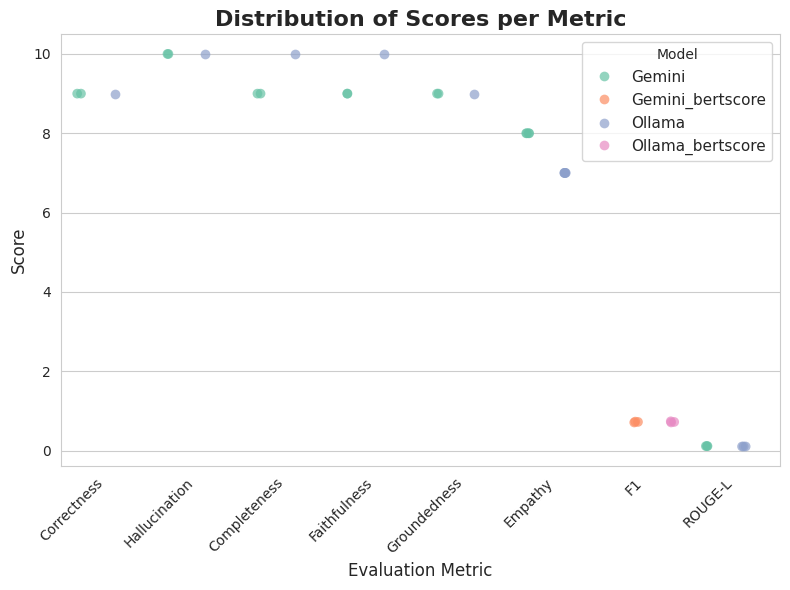

✓ Saved plot2_stripplot.png


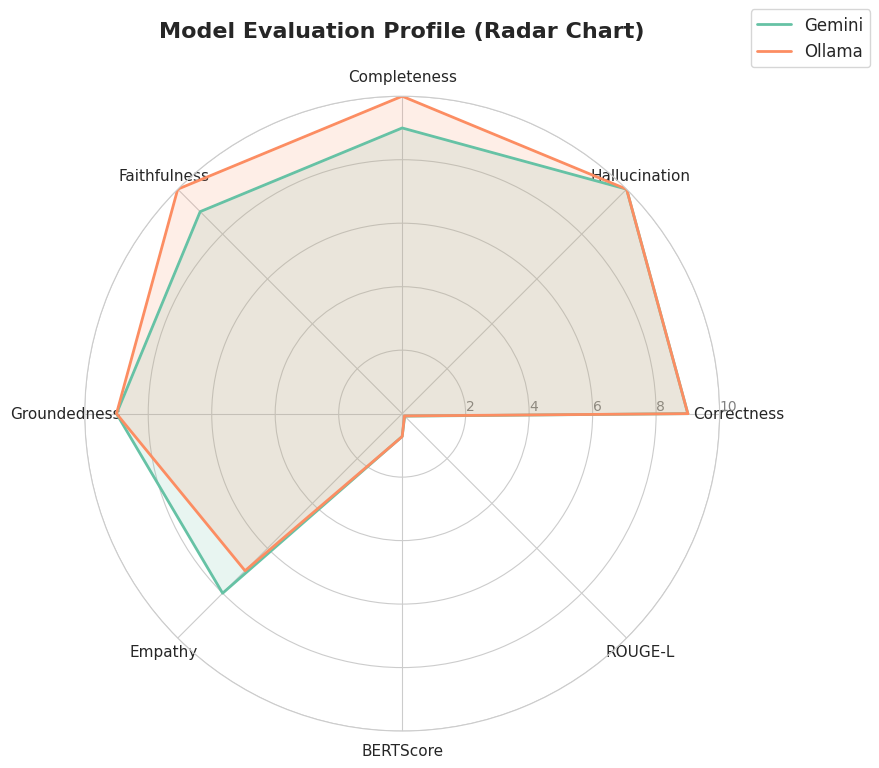

✓ Saved plot3_radar.png


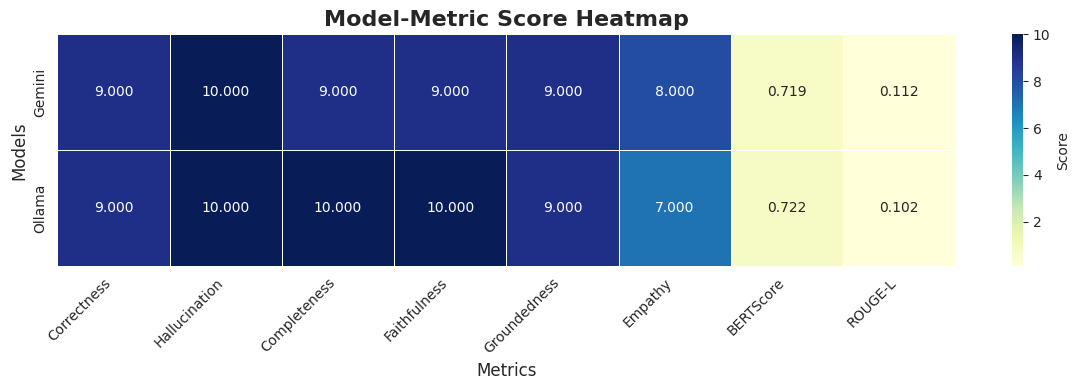

✓ Saved plot4_heatmap.png


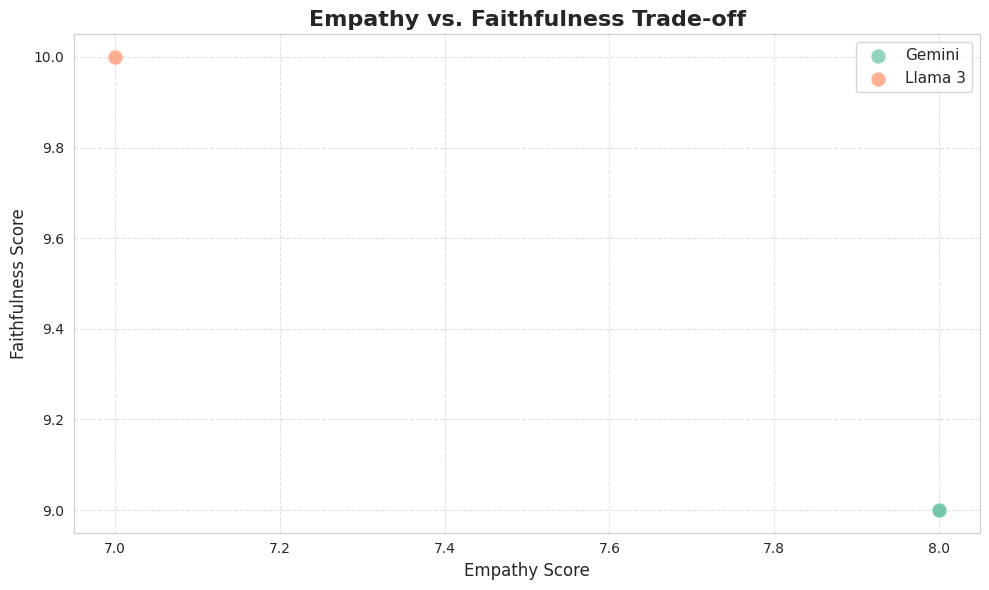

✓ Saved plot5_empathy_faithfulness.png


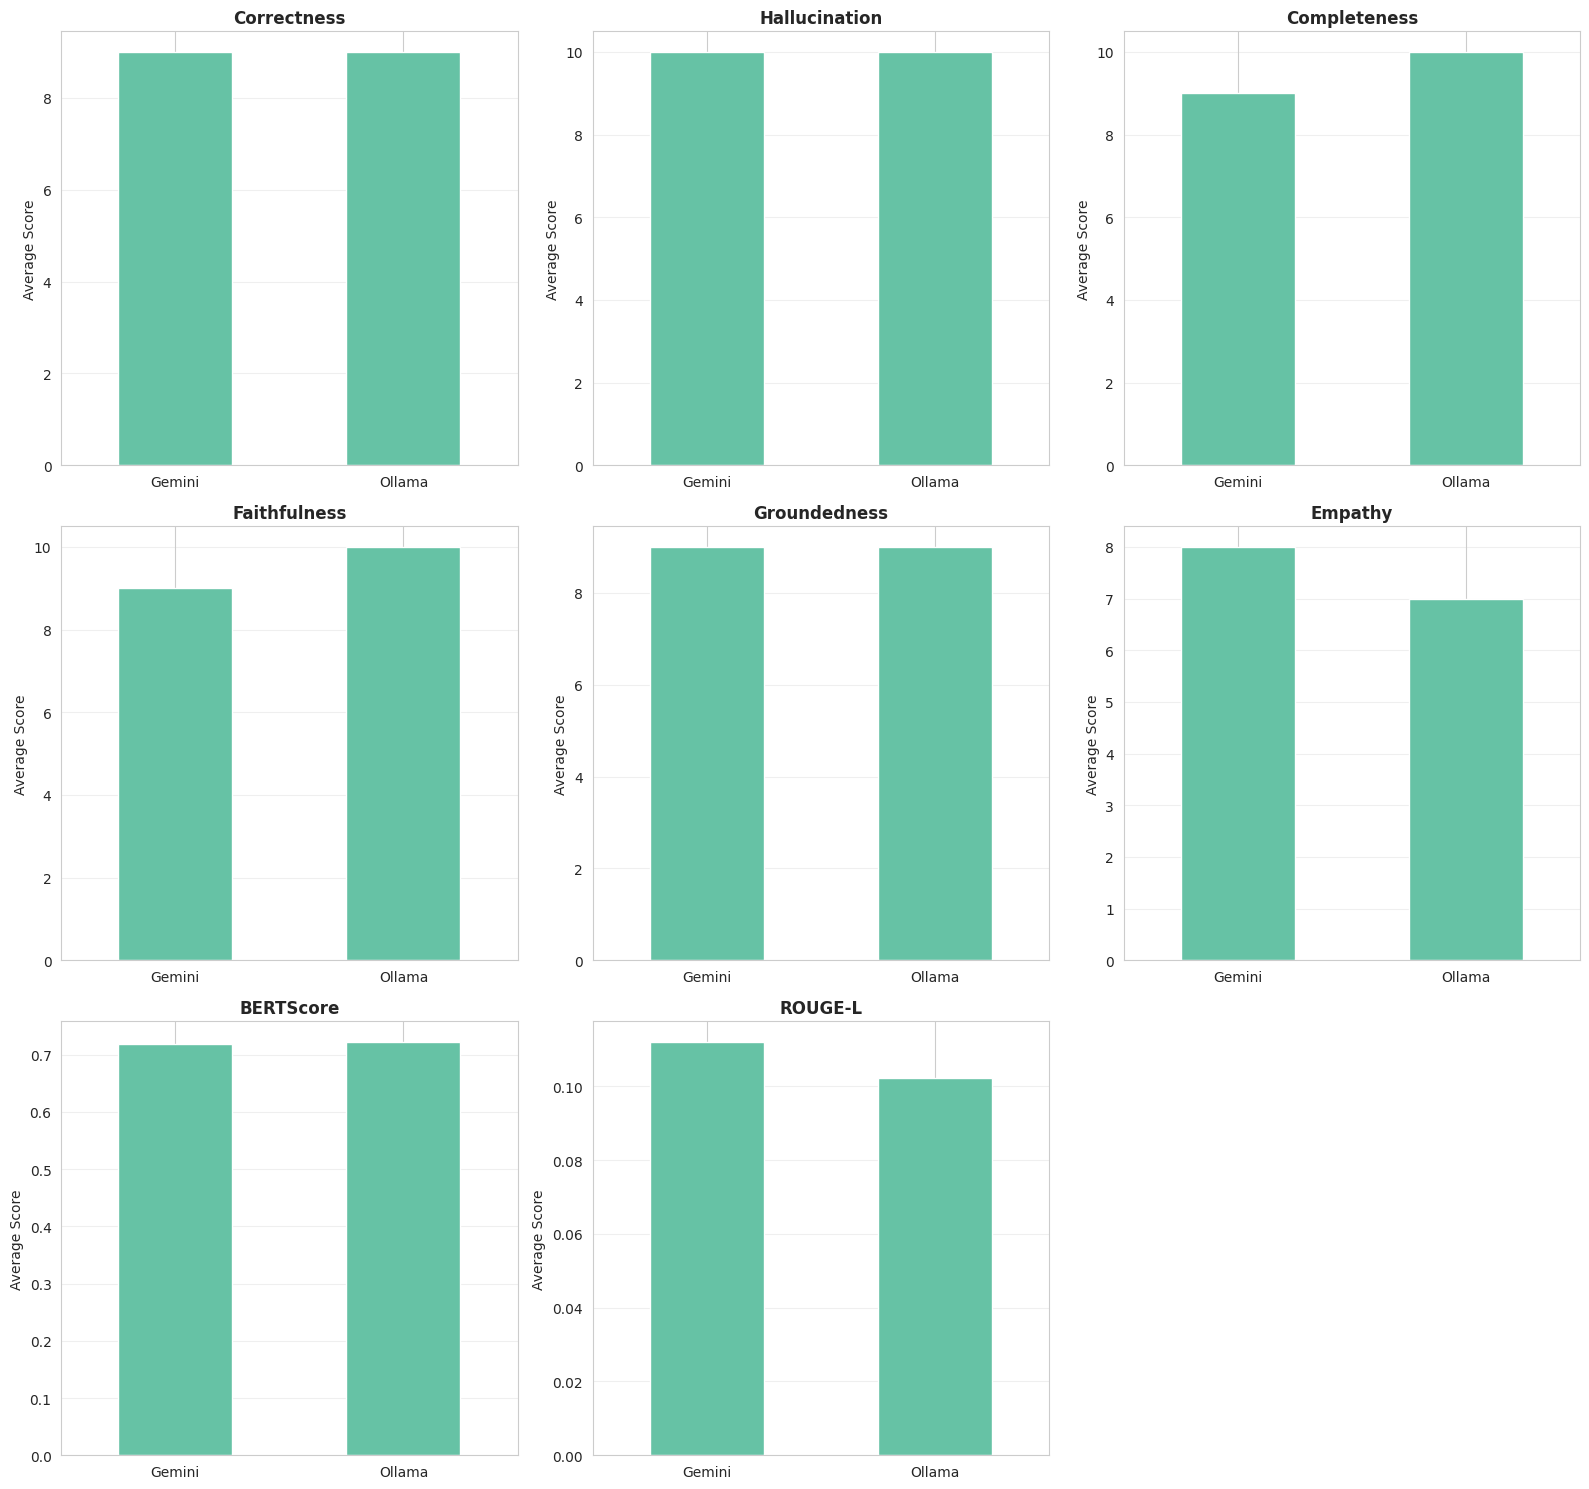

✓ Saved plot6_bar_comparison.png

SUMMARY STATISTICS
 Model        Metric Score (Mean ± Std)
Ollama     BERTScore        0.72 ± 0.01
Gemini     BERTScore        0.72 ± 0.01
Ollama  Completeness        10.00 ± nan
Gemini  Completeness        9.00 ± 0.00
Gemini   Correctness        9.00 ± 0.00
Ollama   Correctness         9.00 ± nan
Gemini       Empathy        8.00 ± 0.00
Ollama       Empathy        7.00 ± 0.00
Ollama  Faithfulness        10.00 ± nan
Gemini  Faithfulness        9.00 ± 0.00
Gemini  Groundedness        9.00 ± 0.00
Ollama  Groundedness         9.00 ± nan
Gemini Hallucination       10.00 ± 0.00
Ollama Hallucination        10.00 ± nan
Gemini       ROUGE-L        0.11 ± 0.00
Ollama       ROUGE-L        0.10 ± 0.00

✓ Saved evaluation_summary.csv

WINNER ANALYSIS
Correctness          | Gemini: 9.000 | Ollama: 9.000 | Winner: Tie
Hallucination        | Gemini: 10.000 | Ollama: 10.000 | Winner: Tie
Completeness         | Gemini: 9.000 | Ollama: 10.000 | Winner: Ollama
Faithfulnes

In [11]:

# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\nGenerating visualizations...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

models = ['gemini', 'ollama']

# Melt DataFrame for seaborn
melted_df = final_df.melt(
    id_vars=['query'],
    value_vars=[f"{model}_{metric}" for model in models for metric in metrics],
    var_name='model_metric',
    value_name='score'
)

# Split model and metric
melted_df[['model', 'metric']] = melted_df['model_metric'].str.extract(r'(\w+)_(.+)')
melted_df['model'] = melted_df['model'].str.capitalize()
melted_df['metric'] = melted_df['metric'].str.replace('_', ' ').str.title()
melted_df['metric'] = melted_df['metric'].str.replace('Bertscore F1', 'BERTScore')
melted_df['metric'] = melted_df['metric'].str.replace('Rougel', 'ROUGE-L')

# --- Plot 1: Boxplot by Metric ---
plt.figure(figsize=(8, 6))
sns.boxplot(data=melted_df, x='metric', y='score', hue='model', palette='Set2')
plt.title('Model Evaluation Scores per Metric', fontsize=16, fontweight='bold')
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', fontsize=11)
plt.tight_layout()
plt.savefig('plot1_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot1_boxplot.png")

# --- Plot 2: Stripplot (Jitter plot) ---
plt.figure(figsize=(8, 6))
sns.stripplot(data=melted_df, x='metric', y='score', hue='model',
              jitter=True, dodge=True, s=7, alpha=0.7, palette='Set2')
plt.title('Distribution of Scores per Metric', fontsize=16, fontweight='bold')
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', fontsize=11)
plt.tight_layout()
plt.savefig('plot2_stripplot.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot2_stripplot.png")

# --- Plot 3: Radar Chart ---
avg_scores = {
    model: [final_df[f"{model.lower()}_{metric}"].mean() for metric in metrics]
    for model in ['Gemini', 'Ollama']
}

labels = [m.replace('_', ' ').title().replace('Bertscore F1', 'BERTScore').replace('Rougel', 'ROUGE-L')
          for m in metrics]
num_vars = len(labels)

angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

plt.figure(figsize=(9, 9))
ax = plt.subplot(111, polar=True)

colors = ['#66c2a5', '#fc8d62']
for idx, model_name in enumerate(['Gemini', 'Ollama']):
    values = avg_scores[model_name]
    values += values[:1]
    ax.plot(angles, values, label=model_name, linewidth=2, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=11)
ax.set_title("Model Evaluation Profile (Radar Chart)", size=16, fontweight='bold', y=1.08)
ax.set_rlabel_position(0)
plt.yticks([2, 4, 6, 8, 10], ["2", "4", "6", "8", "10"], color="grey", size=10)
plt.ylim(0, 10)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=12)
plt.tight_layout()
plt.savefig('plot3_radar.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot3_radar.png")

# --- Plot 4: Heatmap ---
heatmap_df = pd.DataFrame({
    model.capitalize(): [final_df[f"{model.lower()}_{metric}"].mean() for metric in metrics]
    for model in ['Gemini', 'Ollama']
}, index=[m.replace('_', ' ').title().replace('Bertscore F1', 'BERTScore').replace('Rougel', 'ROUGE-L')
          for m in metrics]).T

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu",
            linewidths=0.5, linecolor='white', cbar_kws={'label': 'Score'})
plt.title("Model-Metric Score Heatmap", fontsize=16, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plot4_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot4_heatmap.png")

# --- Plot 5: Empathy vs Faithfulness Scatter ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_df, x='gemini_empathy', y='gemini_faithfulness',
                label='Gemini', alpha=0.7, s=120, color='#66c2a5')
sns.scatterplot(data=final_df, x='ollama_empathy', y='ollama_faithfulness',
                label='Llama 3', alpha=0.7, s=120, color='#fc8d62')

plt.xlabel("Empathy Score", fontsize=12)
plt.ylabel("Faithfulness Score", fontsize=12)
plt.title("Empathy vs. Faithfulness Trade-off", fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('plot5_empathy_faithfulness.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot5_empathy_faithfulness.png")

# --- Plot 6: Bar Chart Comparison ---
# FIXED: Dynamically adjust grid size based on number of metrics

num_metrics = len(metrics)
# Calculate grid dimensions (aim for roughly square layout)
ncols = 3
nrows = (num_metrics + ncols - 1) // ncols  # Ceiling division

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 5 * nrows))

# Flatten axes array for easier indexing (handles both 1D and 2D cases)
if num_metrics == 1:
    axes = [axes]
elif nrows == 1:
    axes = axes
else:
    axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]

    data_to_plot = pd.DataFrame({
        'Gemini': [final_df[f'gemini_{metric}'].mean()],
        'Ollama': [final_df[f'ollama_{metric}'].mean()]
    })

    data_to_plot.T.plot(kind='bar', ax=ax, legend=False, color=['#66c2a5', '#fc8d62'])
    ax.set_title(metric.replace('_', ' ').title().replace('Bertscore F1', 'BERTScore').replace('Rougel', 'ROUGE-L'),
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Score', fontsize=10)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(axis='y', alpha=0.3)

# Hide any unused subplots
for idx in range(num_metrics, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('plot6_bar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved plot6_bar_comparison.png")

# --- Summary Statistics Table ---
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

summary_data = []
for metric in metrics:
    for model in models:
        col = f"{model}_{metric}"
        values = final_df[col].dropna()
        if len(values) > 0:
            mean = values.mean()
            std = values.std()
            summary_data.append({
                "Model": model.capitalize(),
                "Metric": metric.replace('_', ' ').title().replace('Bertscore F1', 'BERTScore').replace('Rougel', 'ROUGE-L'),
                "Score (Mean ± Std)": f"{mean:.2f} ± {std:.2f}",
                "Mean": mean
            })

summary_df = pd.DataFrame(summary_data).sort_values(
    by=["Metric", "Mean"], ascending=[True, False]
).drop(columns='Mean')

print(summary_df.to_string(index=False))
print("="*80)

# Save summary to CSV
summary_df.to_csv("evaluation_summary.csv", index=False)
print("\n✓ Saved evaluation_summary.csv")

# --- Winner Analysis ---
print("\n" + "="*80)
print("WINNER ANALYSIS")
print("="*80)

winner_counts = {'Gemini': 0, 'Ollama': 0, 'Tie': 0}
for metric in metrics:
    gemini_mean = final_df[f'gemini_{metric}'].mean()
    ollama_mean = final_df[f'ollama_{metric}'].mean()

    diff = abs(gemini_mean - ollama_mean)
    if diff < 0.1:  # Consider it a tie if difference is small
        winner = 'Tie'
    elif gemini_mean > ollama_mean:
        winner = 'Gemini'
    else:
        winner = 'Ollama'

    winner_counts[winner] += 1

    metric_name = metric.replace('_', ' ').title().replace('Bertscore F1', 'BERTScore').replace('Rougel', 'ROUGE-L')
    print(f"{metric_name:20} | Gemini: {gemini_mean:.3f} | Ollama: {ollama_mean:.3f} | Winner: {winner}")

print("="*80)
print(f"\nOverall Winners: Gemini: {winner_counts['Gemini']}, Ollama: {winner_counts['Ollama']}, Tie: {winner_counts['Tie']}")
print("="*80)

print("\n✅ EVALUATION COMPLETE!")
print("All plots and summaries have been saved.")